
# Bayesian UQ-SINDy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import pysindy as ps

In [2]:
# set seed for reproducibility
np.random.seed(987)

### Lotka-Volterra Predator-Prey Model

In this example, we generate the data using the Lotka-Volterra equations, which is a simplified model of Predator-Prey interactions. They specify a system of Ordinary Differential Equations (ODEs):
\begin{align}
\frac{dP}{dt} &= a P - b P Q\\
\frac{dQ}{dt} &= c P Q - d Q
\end{align}
where $P$ is the concentration of prey, $Q$ is the concentration of predators, $a$ is the birth rate of prey, $b$ is the death rate of prey, $c$ is the birth rate of predators and $d$ is the death rate of predators.

For more details, see e.g. Rockwood L. L. and Witt J. W. (2015). *Introduction to population ecology*. Wiley Blackwell, Chichester, West Sussex, UK, 2nd edition

In [3]:
# set up a class that defines the Lotka-Volterra equations
class PredatorPreyModel:
    def __init__(self, a=1.0, b=0.3, c=0.2, d=1.0):
        # internalise the model parameters.
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def dydx(self, t, y):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations.}
        return np.array([self.a*y[0] - self.b*y[0]*y[1], self.c*y[0]*y[1] - self.d*y[1]])

    def solve(self, **kwargs):
        # solve the system of ODEs.
        return solve_ivp(self.dydx, **kwargs)

In [4]:
# set some hyperparameters.
t_span = [0, 30]
y0 = np.array([10,5])
max_step = 0.1

# initialise the model and solve.
my_model = PredatorPreyModel()
sol = my_model.solve(t_span=t_span, y0=y0, max_step=max_step)

In [5]:
# the noise level.
noise = 0.1

# extract the timesteps and perturb the solution with noise.
t = sol.t
P = sol.y[0,:] + np.random.normal(scale=noise, size=sol.t.size)
Q = sol.y[1,:] + np.random.normal(scale=noise, size=sol.t.size)

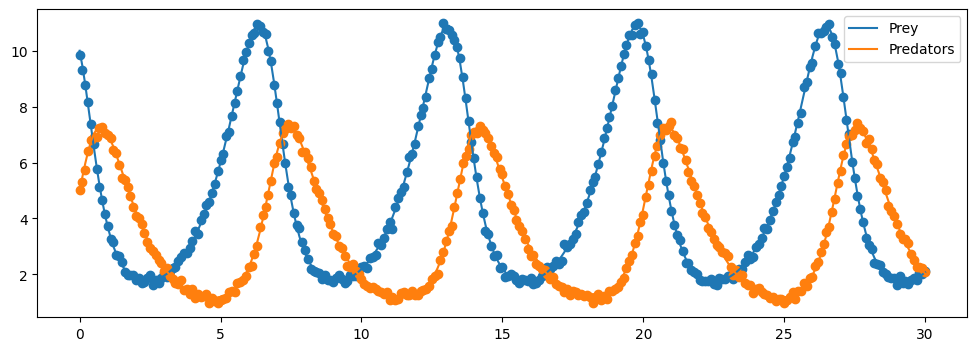

In [6]:
# plot the solution.
plt.figure(figsize=(12,4))
plt.plot(sol.t, sol.y[0,:], label = "Prey")
plt.scatter(t, P)
plt.plot(sol.t, sol.y[1,:], label="Predators")
plt.scatter(t, Q)
plt.legend()
plt.show()

### Bayesian UQ-SINDy

Here we recover the governing equations using UQ-SINDy. For more details on the theory of the method, see Hirsh, S. M., Barajas-Solano, D. A., & Kutz, J. N. (2021). *Sparsifying Priors for Bayesian Uncertainty Quantification in Model Discovery* (arXiv:2107.02107). arXiv. http://arxiv.org/abs/2107.02107

Note that the current implementation differs from the method described in Hirsh et al. (2021) by imposing the error model directly on the derivatives, rather than on the states, circumventing the need to integrate the equation to evaluate the posterior density. One consequence of this is that the noise standard deviation "sigma" is with respect to the derivatives instead of the states and hence should not be interpreted.

The underlying code used to find the posterior distribution of model parameters is `numpyro.infer.MCMC` using the `numpyro.infer.NUTS` kernel. Note that all keyword arguments passed to `pysindy.optimizers.SBR` are sent forward to the [MCMC sampler](https://num.pyro.ai/en/stable/mcmc.html).

In [7]:
# set sampler hyperparameters
sampling_seed = 123

if __name__ == "testing":
    num_warmup = 10
    num_samples = 100
    num_chains = 1
else:
    num_warmup = 500
    num_samples = 2000
    num_chains = 2

In [8]:
# initialise the Sparse bayesian Regression optimizer.
optimizer = ps.optimizers.SBR(num_warmup=num_warmup,
                              num_samples=num_samples,
                              mcmc_kwargs={"seed": sampling_seed,
                                           "num_chains": num_chains})

# use the standard polynomial features.
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True)

# initialise SINDy and fit to the data.
sindy = ps.SINDy(optimizer, feature_library, feature_names=['P', 'Q'])
sindy.fit(np.c_[P, Q], t=t)

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1556.08it/s, 63 steps of size 4.94e-02. acc. prob=0.88]


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['P', 'Q'],
      optimizer=SBR(mcmc_kwargs={'num_chains': 2, 'seed': 123},
                    num_samples=2000, num_warmup=500))

In [9]:
# set up a new differential equation that uses the Bayesian SINDy predictions.
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return sindy.predict(x=_y)

# solve using the Bayesian SINDy equations.
surrogate_sol = solve_ivp(surrogate_dydt, t_span=t_span, y0=y0, max_step=max_step)

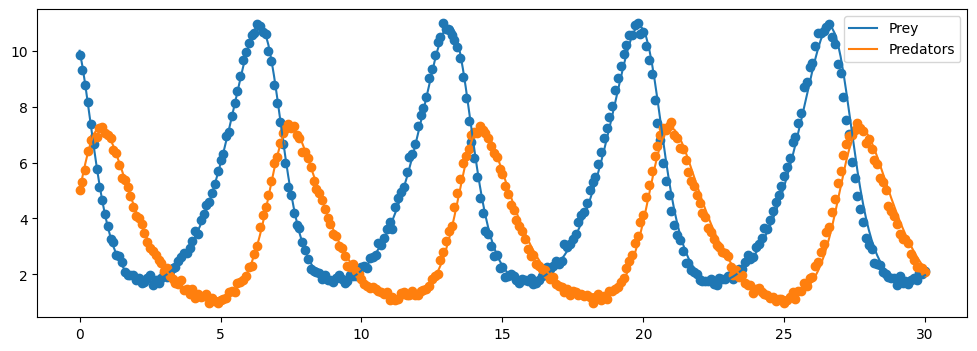

In [10]:
# plot the surrogate solution.
plt.figure(figsize=(12,4))

plt.plot(surrogate_sol.t, surrogate_sol.y[0,:], label = "Prey")
plt.scatter(t, P)

plt.plot(surrogate_sol.t, surrogate_sol.y[1,:], label="Predators")
plt.scatter(t, Q)

plt.legend()
plt.show()

### Get MCMC diagnostics

We can inspect the posterior samples in more detail using `arviz`. Note that this is not included as a dependency of `pysindy` and must be installed separately.

In [11]:
# import arviz.
import arviz as az

In [12]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(sindy.optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.013,0.087,-0.136,0.218,0.003,0.002,1446.0,1099.0,1.0
"beta[0, 1]",0.988,0.044,0.905,1.075,0.001,0.001,1361.0,1500.0,1.0
"beta[0, 2]",0.006,0.036,-0.060,0.083,0.001,0.001,1468.0,1217.0,1.0
"beta[0, 3]",-0.001,0.004,-0.010,0.007,0.000,0.000,1327.0,1372.0,1.0
"beta[0, 4]",-0.296,0.008,-0.311,-0.281,0.000,0.000,2196.0,2365.0,1.0
"beta[0, 5]",-0.003,0.007,-0.016,0.009,0.000,0.000,1452.0,1313.0,1.0
"beta[1, 0]",0.005,0.104,-0.198,0.218,0.003,0.002,1208.0,1029.0,1.0
"beta[1, 1]",0.004,0.032,-0.060,0.071,0.001,0.001,1908.0,1612.0,1.0
"beta[1, 2]",-1.018,0.065,-1.145,-0.900,0.002,0.001,1491.0,1391.0,1.0
"beta[1, 3]",0.000,0.004,-0.006,0.007,0.000,0.000,2073.0,1916.0,1.0


[]

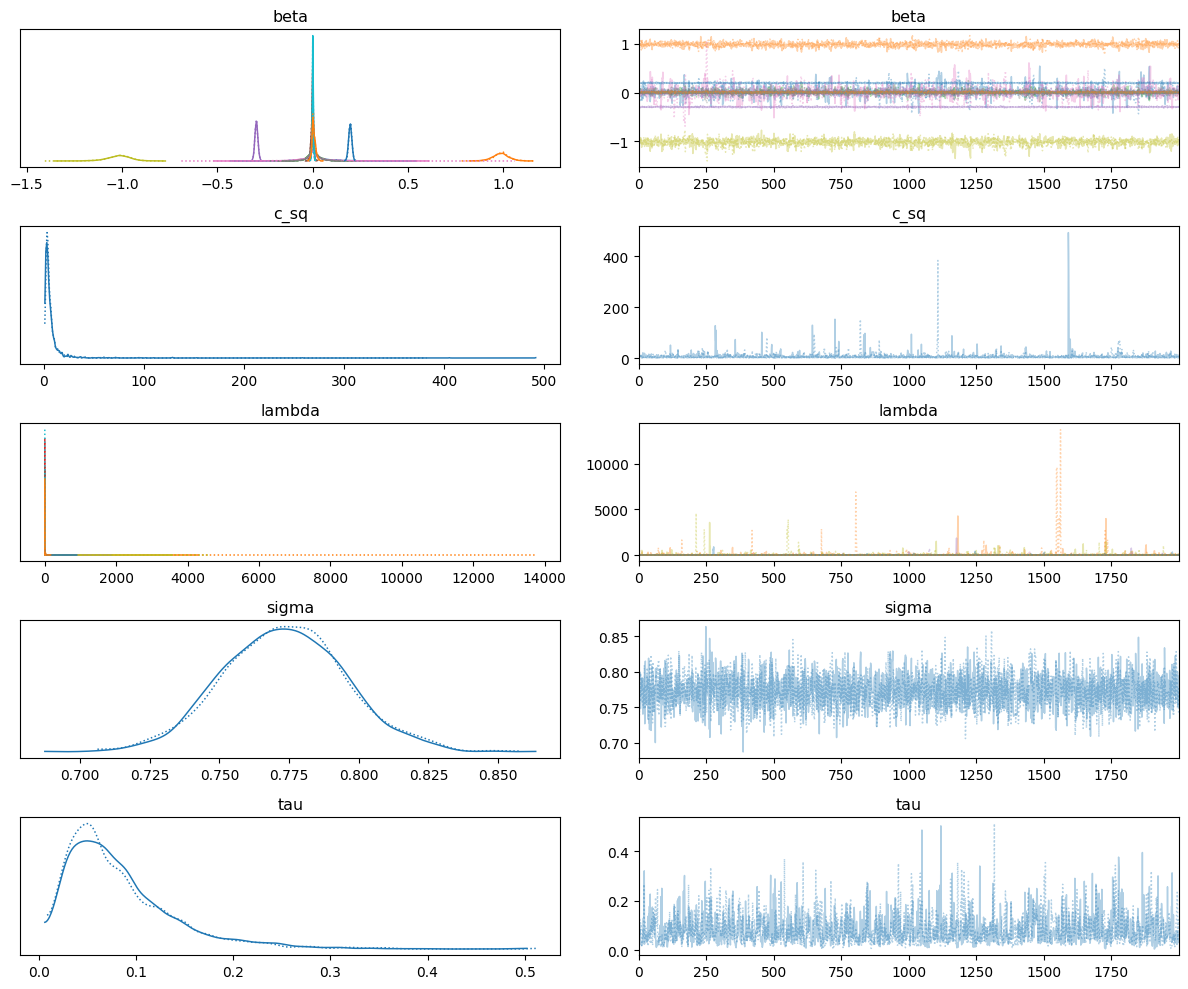

In [13]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()